# Parameter Identification Technique (PIT) on static VCT with a nonlinear VMM model

# Purpose
Is it possible to use a similar regression as used in [04.02_PIT_linear_VMM.ipynb](04.02_PIT_linear_VMM.ipynb) but with data from static Virtual Captive Tests (VCT)?

# Methodology
* Load static data from VCT
* Find the best parameter values in the linear model using OLS linear regression.

# Setup

In [1]:
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt
#if os.name == 'nt':
#    plt.style.use('presentation.mplstyle')  # Windows

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl
import src.models.nonlinear_martin_vmm as vmm
import src.nonlinear_martin_vmm_equations as eq
from src.symbols import *
import src.symbols as symbols
from src import prime_system
from src.models import regression
from src.visualization.plot import track_plot


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


## Load VCT data

In [2]:
df_VCT_all = pd.read_csv('../data/external/vct.csv', index_col=0)
df_VCT_all.head()

,level_0,Dp,S,S_Xgrid,S_inner_bracket_port,S_inner_bracket_stb,S_outer_bracket_port,S_outer_bracket_stb,S_rudder_port,S_rudder_stb,S_shaft_port_assembly,S_shaft_port_shaft1,S_shaft_port_shaft2,S_shaft_stb_assembly,S_shaft_stb_shaft1,S_shaft_stb_shaft2,V,beta,delta,fx,fx_Xgrid,fx_inner_bracket_port,fx_inner_bracket_stb,fx_outer_bracket_port,fx_outer_bracket_stb,fx_rudder_port,fx_rudder_stb,fx_shaft_port_assembly,fx_shaft_port_shaft1,fx_shaft_port_shaft2,fx_shaft_stb_assembly,fx_shaft_stb_shaft1,fx_shaft_stb_shaft2,fy,fy_Xgrid,fy_inner_bracket_port,fy_inner_bracket_stb,fy_outer_bracket_port,fy_outer_bracket_stb,fy_rudder_port,fy_rudder_stb,fy_shaft_port_assembly,fy_shaft_port_shaft1,fy_shaft_port_shaft2,fy_shaft_stb_assembly,fy_shaft_stb_shaft1,fy_shaft_stb_shaft2,fz,fz_Xgrid,fz_inner_bracket_port,fz_inner_bracket_stb,fz_outer_bracket_port,fz_outer_bracket_stb,fz_rudder_port,fz_rudder_stb,fz_shaft_port_assembly,fz_shaft_port_shaft1,fz_shaft_port_shaft2,fz_shaft_stb_assembly,fz_shaft_stb_shaft1,fz_shaft_stb_shaft2,g,lpp,mx,mx_Xgrid,mx_inner_bracket_port,mx_inner_bracket_stb,mx_outer_bracket_port,mx_outer_bracket_stb,mx_rudder_port,mx_rudder_stb,mx_shaft_port_assembly,mx_shaft_port_shaft1,mx_shaft_port_shaft2,mx_shaft_stb_assembly,mx_shaft_stb_shaft1,mx_shaft_stb_shaft2,my,my_Xgrid,my_inner_bracket_port,my_inner_bracket_stb,my_outer_bracket_port,my_outer_bracket_stb,my_rudder_port,my_rudder_stb,my_shaft_port_assembly,my_shaft_port_shaft1,my_shaft_port_shaft2,my_shaft_stb_assembly,my_shaft_stb_shaft1,my_shaft_stb_shaft2,mz,mz_Xgrid,mz_inner_bracket_port,mz_inner_bracket_stb,mz_outer_bracket_port,mz_outer_bracket_stb,mz_rudder_port,mz_rudder_stb,mz_shaft_port_assembly,mz_shaft_port_shaft1,mz_shaft_port_shaft2,mz_shaft_stb_assembly,mz_shaft_stb_shaft1,mz_shaft_stb_shaft2,r,result_file_path,rho,u,v,name,path,thrust,rev,p,phi,model_name,S_BK_port1,S_BK_stb1,fx_BK_port1,fx_BK_stb1,fy_BK_port1,fy_BK_stb1,fz_BK_port1,fz_BK_stb1,mx_BK_port1,mx_BK_stb1,my_BK_port1,my_BK_stb1,mz_BK_port1,mz_BK_stb1,S_daggerboard_middle,fx_daggerboard_middle,fy_daggerboard_middle,fz_daggerboard_middle,mx_daggerboard_middle,my_daggerboard_middle,mz_daggerboard_middle,S_R4083_ref,fx_R4083_ref,fy_R4083_ref,fz_R4083_ref,mx_R4083_ref,my_R4083_ref,mz_R4083_ref,S_Rudder_Center,S_Rudder_Port,S_Rudder_Starboard,S_hull,S_rudder,fx_Rudder_Center,fx_Rudder_Port,fx_Rudder_Starboard,fx_hull,fx_rudder,fy_Rudder_Center,fy_Rudder_Port,fy_Rudder_Starboard,fy_hull,fy_rudder,fz_Rudder_Center,fz_Rudder_Port,fz_Rudder_Starboard,fz_hull,fz_rudder,mx_Rudder_Center,mx_Rudder_Port,mx_Rudder_Starboard,mx_hull,mx_rudder,my_Rudder_Center,my_Rudder_Port,my_Rudder_Starboard,my_hull,my_rudder,mz_Rudder_Center,mz_Rudder_Port,mz_Rudder_Starboard,mz_hull,mz_rudder,torque,test type,eta0,eta0_round,fx_rudders,fy_rudders,fz_rudders,mx_rudders,my_rudders,mz_rudders,clr,S_daggerboard_port,S_daggerboard_stb,fake_index,fx_daggerboard_port,fx_daggerboard_stb,fy_daggerboard_port,fy_daggerboard_stb,fz_daggerboard_port,fz_daggerboard_stb,mx_daggerboard_port,mx_daggerboard_stb,my_daggerboard_port,my_daggerboard_stb,mz_daggerboard_port,mz_daggerboard_stb,$\frac{fx}{V^2}$,$\frac{fy}{V^2}$,$\frac{mz}{V^2}$
0,165,7.3,7375.872,7277.256591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.173333,0.0,-0.000000,-261193.992917,-252076.078409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1308.975604,-295.088406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.879028e+06,-5.881622e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.80665,196.0,5.778834e+02,-1085.233044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.173220e+08,6.178902e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.236840e+05,2.386122e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,L:\proj2019\40199079-Segelfartyg-Wallenius\VCT...,1025.0,6.173333,-0.0,12knotsResistance,L:\proj2019\40199079-Segelfartyg-Wallenius\VCT...,0.0,0.0,0,0,HERO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.61946

In [3]:
df_VCT = df_VCT_all.groupby(by=['model_name']).get_group('V2_5_MDL_modelScale')

In [4]:
df_VCT.describe()

,level_0,Dp,S,S_Xgrid,S_inner_bracket_port,S_inner_bracket_stb,S_outer_bracket_port,S_outer_bracket_stb,S_rudder_port,S_rudder_stb,S_shaft_port_assembly,S_shaft_port_shaft1,S_shaft_port_shaft2,S_shaft_stb_assembly,S_shaft_stb_shaft1,S_shaft_stb_shaft2,V,beta,delta,fx,fx_Xgrid,fx_inner_bracket_port,fx_inner_bracket_stb,fx_outer_bracket_port,fx_outer_bracket_stb,fx_rudder_port,fx_rudder_stb,fx_shaft_port_assembly,fx_shaft_port_shaft1,fx_shaft_port_shaft2,fx_shaft_stb_assembly,fx_shaft_stb_shaft1,fx_shaft_stb_shaft2,fy,fy_Xgrid,fy_inner_bracket_port,fy_inner_bracket_stb,fy_outer_bracket_port,fy_outer_bracket_stb,fy_rudder_port,fy_rudder_stb,fy_shaft_port_assembly,fy_shaft_port_shaft1,fy_shaft_port_shaft2,fy_shaft_stb_assembly,fy_shaft_stb_shaft1,fy_shaft_stb_shaft2,fz,fz_Xgrid,fz_inner_bracket_port,fz_inner_bracket_stb,fz_outer_bracket_port,fz_outer_bracket_stb,fz_rudder_port,fz_rudder_stb,fz_shaft_port_assembly,fz_shaft_port_shaft1,fz_shaft_port_shaft2,fz_shaft_stb_assembly,fz_shaft_stb_shaft1,fz_shaft_stb_shaft2,g,lpp,mx,mx_Xgrid,mx_inner_bracket_port,mx_inner_bracket_stb,mx_outer_bracket_port,mx_outer_bracket_stb,mx_rudder_port,mx_rudder_stb,mx_shaft_port_assembly,mx_shaft_port_shaft1,mx_shaft_port_shaft2,mx_shaft_stb_assembly,mx_shaft_stb_shaft1,mx_shaft_stb_shaft2,my,my_Xgrid,my_inner_bracket_port,my_inner_bracket_stb,my_outer_bracket_port,my_outer_bracket_stb,my_rudder_port,my_rudder_stb,my_shaft_port_assembly,my_shaft_port_shaft1,my_shaft_port_shaft2,my_shaft_stb_assembly,my_shaft_stb_shaft1,my_shaft_stb_shaft2,mz,mz_Xgrid,mz_inner_bracket_port,mz_inner_bracket_stb,mz_outer_bracket_port,mz_outer_bracket_stb,mz_rudder_port,mz_rudder_stb,mz_shaft_port_assembly,mz_shaft_port_shaft1,mz_shaft_port_shaft2,mz_shaft_stb_assembly,mz_shaft_stb_shaft1,mz_shaft_stb_shaft2,r,rho,u,v,thrust,rev,p,phi,S_BK_port1,S_BK_stb1,fx_BK_port1,fx_BK_stb1,fy_BK_port1,fy_BK_stb1,fz_BK_port1,fz_BK_stb1,mx_BK_port1,mx_BK_stb1,my_BK_port1,my_BK_stb1,mz_BK_port1,mz_BK_stb1,S_daggerboard_middle,fx_daggerboard_middle,fy_daggerboard_middle,fz_daggerboard_middle,mx_daggerboard_middle,my_daggerboard_middle,mz_daggerboard_middle,S_R4083_ref,fx_R4083_ref,fy_R4083_ref,fz_R4083_ref,mx_R4083_ref,my_R4083_ref,mz_R4083_ref,S_Rudder_Center,S_Rudder_Port,S_Rudder_Starboard,S_hull,S_rudder,fx_Rudder_Center,fx_Rudder_Port,fx_Rudder_Starboard,fx_hull,fx_rudder,fy_Rudder_Center,fy_Rudder_Port,fy_Rudder_Starboard,fy_hull,fy_rudder,fz_Rudder_Center,fz_Rudder_Port,fz_Rudder_Starboard,fz_hull,fz_rudder,mx_Rudder_Center,mx_Rudder_Port,mx_Rudder_Starboard,mx_hull,mx_rudder,my_Rudder_Center,my_Rudder_Port,my_Rudder_Starboard,my_hull,my_rudder,mz_Rudder_Center,mz_Rudder_Port,mz_Rudder_Starboard,mz_hull,mz_rudder,torque,eta0,eta0_round,fx_rudders,fy_rudders,fz_rudders,mx_rudders,my_rudders,mz_rudders,clr,S_daggerboard_port,S_daggerboard_stb,fx_daggerboard_port,fx_daggerboard_stb,fy_daggerboard_port,fy_daggerboard_stb,fz_daggerboard_port,fz_daggerboard_stb,mx_daggerboard_port,mx_daggerboard_stb,my_daggerboard_port,my_daggerboard_stb,mz_daggerboard_port,mz_daggerboard_stb,$\frac{fx}{V^2}$,$\frac{fy}{V^2}$,$\frac{mz}{V^2}$
count,36.000000,36.0,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,3.600000e+01,3.600000e+01,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,3.600000e+01,3.600000e+01,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,36.000000,36.000000,36.000000,36.000000,3.600000e+01,3.600000e+01,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+

In [5]:
df_VCT['test type'].unique()

array(['resistance', 'Rudder angle', 'Drift angle',
       'Rudder and drift angle', 'Circle', 'Circle + Drift'], dtype=object)

# Subtract the resistance

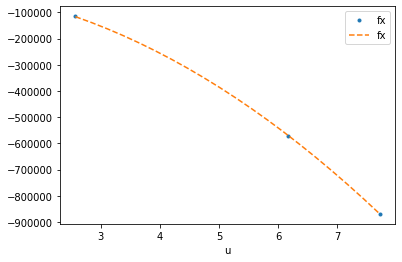

In [6]:
df_resistance = df_VCT.groupby(by='test type').get_group('resistance')

X = df_resistance[['u','fx']].copy()
X['u**2'] = X['u']**2
y = X.pop('fx')

model_resistance = sm.OLS(y,X)
results_resistance = model_resistance.fit()

X_pred = pd.DataFrame()
X_pred['u'] = np.linspace(X['u'].min(), X['u'].max(), 20)
X_pred['u**2'] = X_pred['u']**2
X_pred['fx'] = results_resistance.predict(X_pred)

fig,ax=plt.subplots()
df_resistance.plot(x='u', y='fx', style='.', ax=ax)
X_pred.plot(x='u', y='fx', style='--', ax=ax);


In [7]:
df_VCT_0_resistance = df_VCT.copy()
df_VCT_0_resistance['u**2'] = df_VCT_0_resistance['u']**2
df_VCT_0_resistance['fx']-= results_resistance.predict(df_VCT_0_resistance[['u','u**2']])

## Load test

In [8]:
df_runs = mdl.runs()

In [9]:
#id=22773
#id=22616
#id=22774
id=22770


df, units, meta_data = mdl.load(id=id, dir_path='../data/processed/kalman')
df.index = df.index.total_seconds()
df = df.iloc[0:-100].copy()
df.index-=df.index[0]
df.sort_index(inplace=True)

In [10]:
meta_data['rho']=1000
meta_data['mass'] = meta_data['Volume']*meta_data['rho']
meta_data.dropna()

A0                                                               0.722775
KXX                                                              0.331311
KZZ                                                              1.253641
TA                                                               0.206311
TF                                                               0.206311
Volume                                                           0.441027
angle1                                                               10.0
angle2                                                               10.0
beam                                                             0.946602
comment                                                        ZZ 10/10PS
date                                                           2020-09-24
facility                                                              MDL
file_path_hdf5          \\sspa.local\lab\MeasuredataMDL\40199079\005\0...
gm                                    

In [11]:
df.head()

,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/FxOrder,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/ForceFactor,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/FxOrder,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,Wind/Course,Wind/CourseTreshold,Wind/GWA,lab/WaveHeight,roll,pitch,psi,x0,y0,z0,x01d_gradient,y01d_gradient,z01d_gradient,z02d_gradient,psi1d_gradient,x0_filtered,x01d,x02d,y0_filtered,y01d,y02d,psi_filtered,psi1d,psi2d,u,v,w,u1d,v1d,w1d,r,r1d,beta
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,0.0,1.0,2.146755,0.000930,0.244419,0.0,-0.520477,10.131507,1.0,2.146755,-0.024623,0.122683,0.0,2.144633,11.329219,-0.000651,-0.009621,-0.007185,-0.002344,0.006963,0.008156,9.597722,5.567396,-0.113822,9.546612,5.328476,0.104278,-0.000007,0.645772,14.89,-0.005037,0.1,0.0,0.000025,0.000927,0.000325,-0.000873,7.611185,-0.001594,0.002499,1.020600,-0.003508,-0.022730,1.867924,0.017441,7.630116,0.932272,0.000005,-0.001617,0.000065,-6.810068e-07,-0.000821,0.000001,-0.000004,0.932272,0.000830,-0.022730,0.000005,-6.766628e-07,1.867924,0.000001,-0.000004,-0.000890
0.010007,0.0,1.0,2.146755,0.000832,0.121932,0.0,-0.288911,10.131507,1.0,2.146755,-0.022034,0.126699,0.0,1.025401,11.329219,0.012245,-0.012845,-0.014928,-0.012007,0.019213,0.003000,9.572657,5.679435,-0.110951,9.558256,5.397689,0.106811,-0.000007,0.645772,14.89,-0.004507,0.1,0.0,0.000025,0.000972,-0.000254,-0.000698,7.621398,-0.001629,0.002271,0.508139,0.000864,-0.004038,1.308212,0.013081,7.625826,0.921355,-0.002257,-0.001613,0.000114,-1.514633e-05,-0.000735,-0.000025,-0.000024,0.921354,0.000791,-0.004038,-0.002257,-1.680414e-05,1.308212,-0.000025,-0.000024,-0.000859
0.020011,0.0,1.0,2.146755,0.000736,-0.120384,0.0,0.000545,10.131507,1.0,2.146755,-0.019471,0.025530,0.0,1.913068,11.329219,-0.001296,-0.012200,-0.029125,0.002810,0.021792,0.002356,9.514150,5.728091,-0.107321,9.562515,5.484805,0.109010,0.000000,0.645772,14.89,-0.003983,0.1,0.0,0.000025,0.000915,0.000341,-0.000611,7.621356,-0.001577,0.002418,0.952405,0.001934,0.003452,0.258792,-0.008754,7.627892,0.921396,-0.003307,-0.001587,0.000145,-2.490043e-05,-0.000702,-0.000131,-0.000054,0.921396,0.000792,0.003452,-0.003307,-2.722338e-05,0.258792,-0.000131,-0.000054,-0.000860
0.030001,0.0,1.0,2.146755,0.000638,-0.310377,0.0,0.521567,10.131507,1.0,2.146755,-0.016901,-0.089957,0.0,0.639459,11.329219,0.005152,-0.012845,-0.016219,-0.005565,0.007608,-0.001511,9.541821,5.700100,-0.104350,9.587783,5.548451,0.110168,0.000000,0.645772,14.89,-0.003457,0.1,0.0,0.000025,0.000945,-0.000327,-0.000873,7.640413,-0.001590,0.002341,1.483970,0.002393,0.001150,-0.262092,-0.008748,7.639433,0.923933,-0.002592,-0.001575,0.000151,-3.795793e-05,-0.000805,-0.000191,-0.000113,0.923932,0.000895,0.001150,-0.002592,-4.004497e-05,-0.262092,-0.000191,-0.000113,-0.000969
0.040001,0.0,1.0,2.146755,0.000549,-0.303348,0.0,0.463676,10.131507,1.0,2.146755,-0.014543,-0.130523,0.0,-0.749933,11.329219,0.007087,-0.017357,-0.023318,-0.001700,0.017924,-0.002155,9.514368,5.613694,-0.103258,9.562679,5.586684,0.110073,0.000000,0.645772,14.89,-0.002975,0.1,0.0,0.000025,0.000929,0.000426,-0.000785,7.651012,-0.001529,0.002441,0.931076,0.003854,-0.001788,0.240757,-0.000002,7.649572,0.924786,-0.002156,-0.001540,0.000128,-4.577976e-05,-0.000809,-0.000182,-0.000150,0.924785,0.000876,-0.001788,-0.002156,-4.752416e-05,0.240757,-0.000182,-0.000150,-0.000948


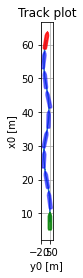

In [12]:
from src.visualization.plot import track_plot
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

# Ship parameters

In [13]:
T_ = (meta_data.TA + meta_data.TF)/2
L_ = meta_data.lpp
m_ = meta_data.mass
rho_ = meta_data.rho
B_ = meta_data.beam
CB_ = m_/(T_*B_*L_*rho_)
volume_ = m_/rho_
I_z_ = m_*meta_data.KZZ**2

ship_parameters = {
        'T' : T_,
        'L' : L_,
        'CB' :CB_,
        'B' : B_,
        'rho' : rho_,
        'x_G' : meta_data.lcg,  # motions are expressed at CG
        'm' : m_,
        'I_z': I_z_, 
        'volume':volume_,
    }

ps = prime_system.PrimeSystem(**ship_parameters)  # model

scale_factor = meta_data.scale_factor
ps_ship = prime_system.PrimeSystem(L=ship_parameters['L']*scale_factor, rho=meta_data['rho'])  # ship

# VCT to prime system

In [14]:
interesting = [
    'u',
    'v',
    'r',
    'delta',
    'fx',
    'fy',
    'mz',
    'thrust',
]
df_VCT_prime = ps_ship.prime(df_VCT_0_resistance[interesting], U=df_VCT_0_resistance['V'])

In [15]:
df_VCT_prime.describe()

,u,v,r,delta,fx,fy,mz,thrust
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.0
mean,0.996958,-0.052229,-0.090617,-0.012120,-0.000033,0.000321,0.000326,0.0
std,0.004359,0.058503,0.141170,0.089367,0.000057,0.001123,0.000386,0.0
min,0.984808,-0.173648,-0.500000,-0.261799,-0.000229,-0.001346,-0.000413,0.0
25%,0.994522,-0.104528,-0.199056,-0.000000,-0.000062,-0.000541,0.000087,0.0
50%,0.998782,-0.034878,0.000000,-0.000000,-0.000009,0.000073,0.000241,0.0
75%,1.000000,0.000000,0.000000,0.000000,0.000001,0.001122,0.000565,0.0
max,1.000000,-0.000000,0.000000,0.226893,0.000031,0.002374,0.001345,0.0


# Nonlinear Vessel Manoeuvring Model (VMM)
Implementing according to:
Matusiak, Jerzy. Dynamics of a Rigid Ship. Aalto University, 2017. https://aaltodoc.aalto.fi:443/handle/123456789/24408.

## N
The yaw is described by the following Ordinary Differential Equation (ODE):

In [16]:
Math(vlatex(eq.N_eq))

<IPython.core.display.Math object>

The hydrodynamic moment part of this model is:

In [17]:
Math(vlatex(eq.mz_eq))

<IPython.core.display.Math object>

In [18]:
N_eq = eq.mz_eq.subs(eq.N_qs,sp.solve(eq.N_qs_eq,N_qs)[0])
Math(vlatex(N_eq))

<IPython.core.display.Math object>

In [19]:
N_eq = N_eq.subs([
    #(x_G,0),  # Assuming or moving to CG=0
    #(I_z,1),  # Removing inertia
    #(eq.p.Nrdot,0),  # Removing added mass
    
    (u.diff(),0),
    (v.diff(),0),
    (r.diff(),0),

    
])  

#solution = sp.solve(N_eq,r.diff())[0]
#N_eq = sp.Eq(r.diff(), solution*(I_z-eq.p.Nrdot))  # Putting r1d on the LHS

In [20]:
diff_eq_N = regression.DiffEqToMatrix(ode=N_eq, label=N_nonlin, base_features=[delta,u,v,r])

If accelerations (dotted states) are dropped from this equation, the quasi-static force model is obtained:

In [21]:
Math(vlatex(diff_eq_N.acceleration_equation))

<IPython.core.display.Math object>

This is a model that now only depend on steady velocities and rudder angle and will be the same thing as the forces/moment coming from the VCT calculations (CFD):

$ m_{z}^{VCT} = N_{lin} $

The hydrodynamic derivatives (the parameters in the matematical model) can be regressed by solving the following linear regression problem:

$ y = X \cdot \beta + \epsilon $

Where $y$ and $X$ and $\beta$ are:

In [22]:
Math(vlatex(diff_eq_N.acceleration_equation_x))

<IPython.core.display.Math object>

In [23]:
Math(vlatex(diff_eq_N.eq_y))

<IPython.core.display.Math object>

In [24]:
diff_eq_N.eq_beta

Eq(beta, Matrix([
[    N_{rr}],
[N_{udelta}],
[ N_{delta}],
[     N_{r}],
[     N_{u}],
[     N_{v}]]))

In [25]:
Math(vlatex(diff_eq_N.eq_X))

<IPython.core.display.Math object>

In [26]:
diff_eq_N.X_lambda

<function _lambdifygenerated(delta, r, u, v)>

In [27]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def show_pred(X,y,results, label):
    
    display(results.summary())
    
    X_ = X.copy()
    X_['y'] = y
    X_.sort_values(by='y', inplace=True)
        
    y_ = X_.pop('y')
    
    y_pred = results.predict(X_)
    
    prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)
    #iv_l*=-1 
    #iv_u*=-1
    
    fig,ax=plt.subplots()
    #ax.plot(X_.index,y_, label='Numerical gradient from model test')
    #ax.plot(X_.index,y_pred, '--', label='OLS')
    
    ax.plot(y_,y_pred, '.')
    ax.plot([y_.min(),y_.max()], [y_.min(),y_.max()], 'r-')
    
    ax.set_ylabel(f'{label} (prediction)')    
    ax.set_xlabel(label)
    
    ax.fill_between(y_, y1=iv_l, y2=iv_u, zorder=-10, color='grey', alpha=0.5, label=r'5% confidence')
    ax.legend();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     mz   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              779.3
Date:                Wed, 07 Jul 2021   Prob (F-statistic):                    1.57e-31
Time:                        17:50:18   Log-Likelihood:                          313.46
No. Observations:                  36   AIC:                                     -614.9
Df Residuals:                      30   BIC:                                     -605.4
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Nrr           -0.0010      0.000     -2.343      0.026      -0.002      -0.000
Nudelta        0.0090      0.040      0.226      0.823      -0.072       0.090
Ndelta        -0.0116      0.040     -0.293      0.772      -0.093       0.069
Nr            -0.0023      0.000    -12.889      0.000      -0.003      -0.002
Nu         -3.991e-05   1.58e-05     -2.523      0.017   -7.22e-05   -7.61e-06
Nv            -0.0020      0.000    -13.076      0.000      -0.002      -0.002
==============================================================================
Omnibus:                       13.826   Durbin-Watson:                   1.164
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.552
Skew:                           1.060   Prob(JB):                     0.000154
Kurtosis:                       5.684   Cond. No.                     7.70e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

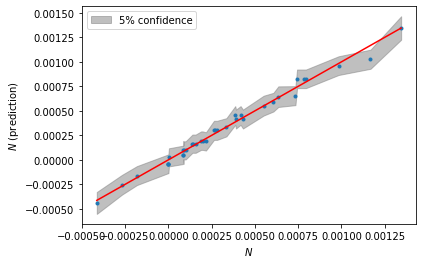

In [28]:
X = diff_eq_N.calculate_features(data=df_VCT_prime)
y = diff_eq_N.calculate_label(y=df_VCT_prime['mz'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred(X=X,y=y,results=results_N, label=r'$N$')

## Y

In [29]:
Math(vlatex(eq.Y_eom))

<IPython.core.display.Math object>

In [30]:
Y_eq = eq.fy_eq.subs(eq.Y_qs,sp.solve(eq.Y_qs_eq,Y_qs)[0])
Math(vlatex(Y_eq))

<IPython.core.display.Math object>

In [31]:
Y_eq = Y_eq.subs([
    #(eq.p.Yvdot,1),  # Removing added mass
    #(x_G,0),  
    (u.diff(),0),
    (v.diff(),0),
    (r.diff(),0),
    
])  
#solution = sp.solve(Y_eq,v.diff())[0]
#solution = solution*(-eq.p.Yvdot+m)
#solution = solution + U*m*r# (adding u*m*r to the measurement fy instead)  
#Y_eq = sp.simplify(sp.Eq(v.diff(), solution))  # Putting r1d on the LHS

In [32]:
Math(vlatex(Y_eq))

<IPython.core.display.Math object>

In [33]:
diff_eq_Y = regression.DiffEqToMatrix(ode=Y_eq, label=Y_nonlin, base_features=[delta,u,v,r])

In [34]:
diff_eq_Y.eq_beta

Eq(beta, Matrix([
[    Y_{vv}],
[Y_{udelta}],
[ Y_{delta}],
[     Y_{r}],
[     Y_{u}],
[     Y_{v}]]))

In [35]:
diff_eq_Y.acceleration_equation_x

Eq(y, Y_{delta}*x_3 + Y_{r}*x_4 + Y_{udelta}*x_2 + Y_{u}*x_5 + Y_{vv}*x_1 + Y_{v}*x_6)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fy   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              1396.
Date:                Wed, 07 Jul 2021   Prob (F-statistic):                    2.63e-35
Time:                        17:50:19   Log-Likelihood:                          293.90
No. Observations:                  36   AIC:                                     -575.8
Df Residuals:                      30   BIC:                                     -566.3
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Yvv           -0.0232      0.005     -5.134      0.000      -0.032      -0.014
Yudelta       -0.0360      0.068     -0.533      0.598      -0.174       0.102
Ydelta         0.0406      0.067      0.602      0.552      -0.097       0.178
Yr             0.0023      0.000     22.609      0.000       0.002       0.003
Yu         -7.488e-05   2.69e-05     -2.784      0.009      -0.000   -1.99e-05
Yv            -0.0100      0.001    -14.115      0.000      -0.011      -0.009
==============================================================================
Omnibus:                        8.152   Durbin-Watson:                   1.007
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                6.828
Skew:                           0.884   Prob(JB):                       0.0329
Kurtosis:                       4.193   Cond. No.                     7.61e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

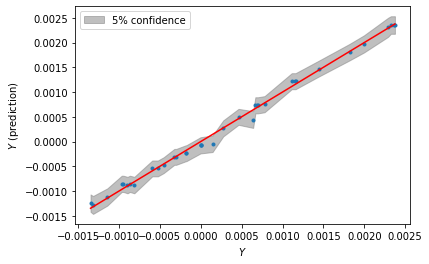

In [36]:
X = diff_eq_Y.calculate_features(data=df_VCT_prime, simplify_names=True)
y = diff_eq_Y.calculate_label(y=df_VCT_prime['fy'])
#y+=df['u']*df['r']  # adding centrifugal force

model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred(X=X,y=y,results=results_Y, label=r'$Y$')

In [37]:
X.head()

,Yvv,Yudelta,Ydelta,Yr,Yu,Yv
494,-0.0,-0.000000,-0.000000,0.0,1.0,-0.0
495,-0.0,-0.000000,-0.000000,0.0,1.0,-0.0
496,-0.0,-0.000000,-0.000000,0.0,1.0,-0.0
497,-0.0,-0.174533,-0.174533,0.0,1.0,-0.0
498,-0.0,-0.226893,-0.226893,0.0,1.0,-0.0


## X

In [38]:
X_eq = eq.fx_eq.subs(eq.X_qs,sp.solve(eq.X_qs_eq,X_qs)[0])
Math(vlatex(X_eq))

<IPython.core.display.Math object>

In [39]:

X_eq = X_eq.subs([
    #(eq.p.Xudot,1),  # Removing added mass
    (u.diff(),0),
    (v.diff(),0),
    (r.diff(),0),
    #(m,0),  # mass
    
])  

#solution = sp.solve(X_eq,u.diff())[0]
#X_eq = sp.Eq(u.diff(), solution*(-eq.p.Xudot+m))  # Putting r1d on the LHS

In [40]:
Math(vlatex(X_eq))

<IPython.core.display.Math object>

In [41]:
diff_eq_X = regression.DiffEqToMatrix(ode=X_eq, label=X_nonlin, base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fx   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.900
Method:                 Least Squares   F-statistic:                              81.72
Date:                Wed, 07 Jul 2021   Prob (F-statistic):                    2.49e-16
Time:                        17:50:20   Log-Likelihood:                          339.21
No. Observations:                  36   AIC:                                     -670.4
Df Residuals:                      32   BIC:                                     -664.1
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Xdeltadelta    -0.0029      0.000    -14.201      0.000      -0.003      -0.003
Xvv            -0.0010      0.000     -2.504      0.018      -0.002      -0.000
Xvr            -0.0035      0.000     -7.662      0.000      -0.004      -0.003
Xu           5.751e-06   4.86e-06      1.184      0.245   -4.14e-06    1.56e-05
==============================================================================
Omnibus:                       13.548   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.432
Skew:                          -0.946   Prob(JB):                     6.03e-05
Kurtosis:                       6.062   Cond. No.                         133.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

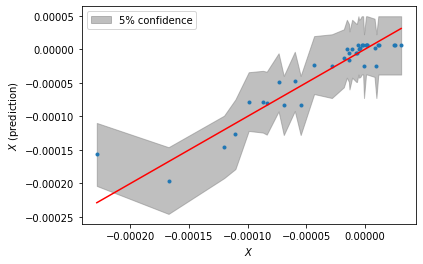

In [42]:
X = diff_eq_X.calculate_features(data=df_VCT_prime)
y = diff_eq_X.calculate_label(y=df_VCT_prime['fx'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred(X=X,y=y,results=results_X, label=r'$X$')

In [43]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

# Brix parameters

In [44]:
def calculate_prime(row, ship_parameters):
    return run(function=row['brix_lambda'], inputs=ship_parameters)

mask = df_parameters['brix_lambda'].notnull()
df_parameters.loc[mask,'brix_prime'] = df_parameters.loc[mask].apply(calculate_prime, ship_parameters=ship_parameters, axis=1)
df_parameters.loc['Ydelta','brix_prime'] = 0.005  # Just guessing
df_parameters.loc['Ndelta','brix_prime'] = -df_parameters.loc['Ydelta','brix_prime']/2  # Just guessing
df_parameters['brix_prime'].fillna(0, inplace=True)

## Add the regressed parameters
Hydrodynamic derivatives that depend on acceleration cannot be obtained from the VCT regression. They are however essential if a time simulation should be conducted. These values have then been taken from Brix semi empirical formulas for the simulations below.

In [45]:
df_parameters_all = df_parameters.copy()
for other in [results_summary_X, results_summary_Y, results_summary_N]:
    df_parameters_all = df_parameters_all.combine_first(other)

df_parameters_all.rename(columns={'coeff':'regressed'}, inplace=True)
df_parameters_all.drop(columns=['brix_lambda'], inplace=True)

df_parameters_all['prime'] = df_parameters_all['regressed'].combine_first(df_parameters_all['brix_prime'])  # prefer regressed

In [46]:
df_parameters_all

,$P_{value}$,$conf_{higher}$,$conf_{lower}$,brix,brix_prime,regressed,coord,dof,state,symbol,prime
Ndelta,7.717562e-01,0.069332,-0.092532,NaN,-0.002500,-0.011600,delta,N,,N_{delta},-0.011600
Ndeltadelta,NaN,NaN,NaN,NaN,0.000000,NaN,deltadelta,N,,N_{deltadelta},0.000000
Ndeltadeltadelta,NaN,NaN,NaN,NaN,0.000000,NaN,deltadeltadelta,N,,N_{deltadeltadelta},0.000000
Nr,9.156908e-14,-0.001901,-0.002616,-pi*T**2*(0.039*B/T - 0.56*B/L + 0.25)/L**2,-0.001719,-0.002258,r,N,,N_{r},-0.002258
Nrdelta,NaN,NaN,NaN,NaN,0.000000,NaN,rdelta,N,,N_{rdelta},0.000000
Nrdeltadelta,NaN,NaN,NaN,NaN,0.000000,NaN,rdeltadelta,N,,N_{rdeltadelta},0.000000
Nrdot,NaN,NaN,NaN,-pi*T**2*(0.017*B*CB/T - 0.33*B/L + 0.08333333...,-0.000299,NaN,r,N,dot,N_{\dot{r}},-0.000299
Nrr,2.598145e-02,-0.000131,-0.001915,NaN,0.000000,-0.001023,rr,N,,N_{rr},-0.001023
Nrrdelta,NaN,NaN,NaN,NaN,0.000000,NaN,rrdelta,N,,N_{rrdelta},0.000000
Nrrr,NaN,NaN,NaN,NaN,0.000000,NaN,rrr,N,,N_{rrr},0.000000


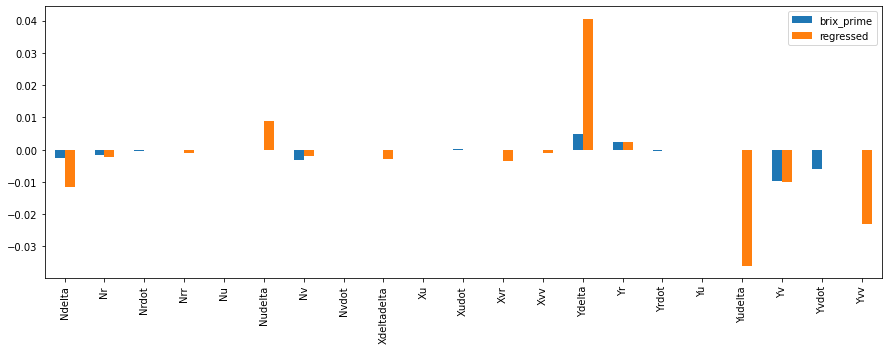

In [47]:
fig,ax=plt.subplots()
fig.set_size_inches(15,5)
mask = ((df_parameters_all['brix_prime'] != 0) |
        (df_parameters_all['regressed']).notnull())
        
df_parameters_plot = df_parameters_all.loc[mask]
df_parameters_plot.plot.bar(y=['brix_prime','regressed'], ax=ax);

It seems that the regressed hydrodynamic derivatives are reasonable similar to the corresponding predicted values with semi-empirical formulas from Brix.

# Simulation

<AxesSubplot:xlabel='time'>

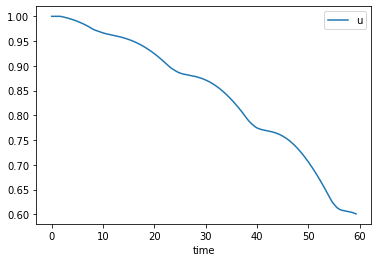

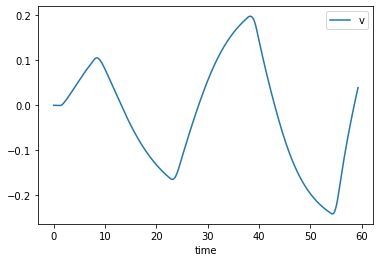

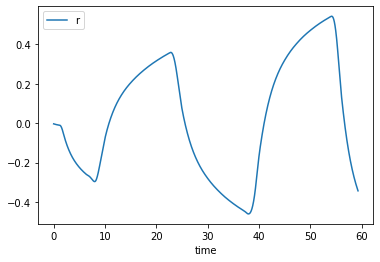

In [48]:
df_ = df.copy()
t = df_.index
control = df_[['delta']]
#control = {'delta':0,}

df_0 = df_.iloc[0:100].median(axis=0)
y0 = {
    'u' : df_0['u'], 
    'v' : df_0['v'],
    'r' : df_0['r'],
    'x0' : df_0['x0'],
    'y0' : df_0['y0'],
    'psi' : df_0['psi'],
    }

#solution = model.simulate(y0=y0, t=t, df_parameters=df_parameters, df_ship_parameters=df_ship_parameters, control=control, rtol=1e-3, atol=1e-3)
simulation = vmm.NonLinearSimulation()
solution = simulation.simulate(y0=y0, t=t, df_parameters=df_parameters_all, ship_parameters=ship_parameters, control=control)

columns = list(y0.keys())
df_result_prime = pd.DataFrame(data=solution.y.T, columns=columns)
df_result_prime.index=t[0:len(df_result_prime)]

#df_result_prime['U'] = np.sqrt(df_result_prime['u']**2 + df_result_prime['v']**2)

df_result_prime.plot(y='u')
df_result_prime.plot(y='v')
df_result_prime.plot(y='r')


In [49]:
U_ = np.sqrt(df_0['u']**2 + df_0['v']**2)
df_result = ps.unprime(values=df_result_prime, U=U_)
df_result['beta'] = -np.arctan2(df_result['v'],df_result['u'])

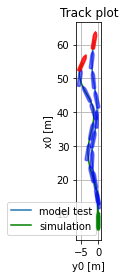

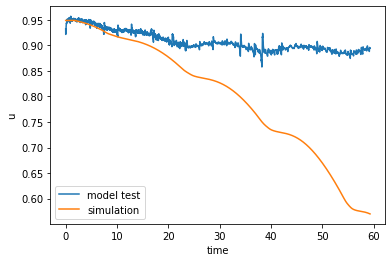

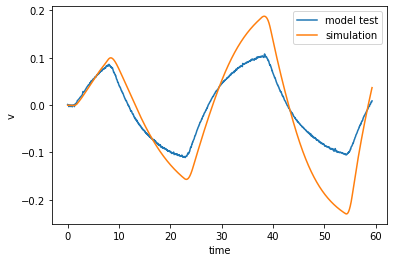

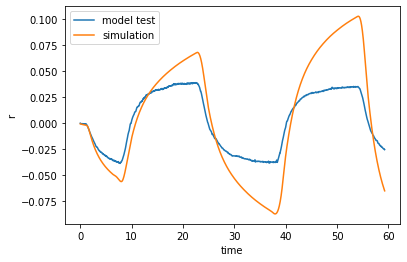

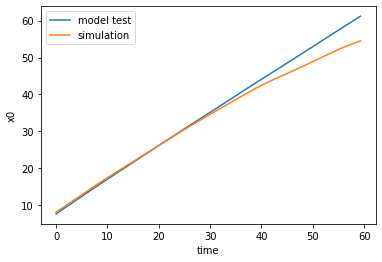

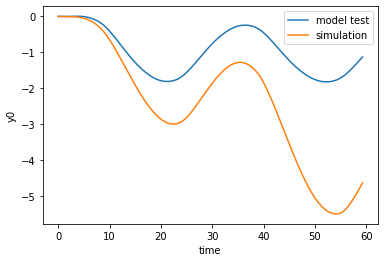

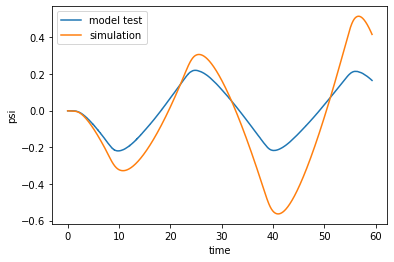

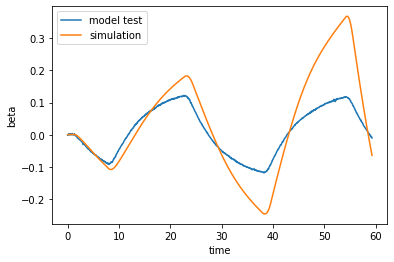

In [50]:
fig,ax=plt.subplots()
track_plot(df=df, lpp=ship_parameters['L'], beam=ship_parameters['B'],ax=ax, label='model test')
track_plot(df=df_result, lpp=ship_parameters['L'], beam=ship_parameters['B'],ax=ax, label='simulation', color='green')
ax.legend()


for key in df_result:
    fig,ax = plt.subplots()
    df.plot(y=key, label='model test', ax=ax)
    df_result.plot(y=key, label='simulation', ax=ax)
    ax.set_ylabel(key)

